In [43]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [44]:
# Setting the seeds for reproducibility
import random
import numpy as np
import pandas as pd
import tensorflow as tf

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [45]:
# Importing the dependencies
import os
import json # To load the kaggle json file
from zipfile import ZipFile # We will get a zip file which we need to extract for which we are using this library
from PIL import Image
import keras as kr

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models

In [46]:
kaggle_credentials = None
with open('../../../kaggle.json') as file:
    kaggle_credentials = json.load(file)

print(kaggle_credentials)

{'username': 'souryadipmallick96', 'key': 'ba0b5bd5911737eeea25652a924b144e'}


In [47]:
# Setting up this data as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials.get('username')
os.environ['KAGGLE_KEY'] = kaggle_credentials.get('key')

In [48]:
# # Now we need to unzip the zipfile that we have downloaded
# with ZipFile('archive.zip') as zipfile:
#     zipfile.extractall() # This will extract all the files from the zipfile

In [49]:
print(os.listdir("plantvillage dataset")) # Number of directories inside this folder
print(len(os.listdir("plantvillage dataset/color")))

['color', 'grayscale', 'segmented']
38


In [50]:
# We will mainly focus on the color images
dataset_path = "plantvillage dataset/color"

!ls

experiment.ipynb
plantvillage dataset


Shape: (256, 256, 3)


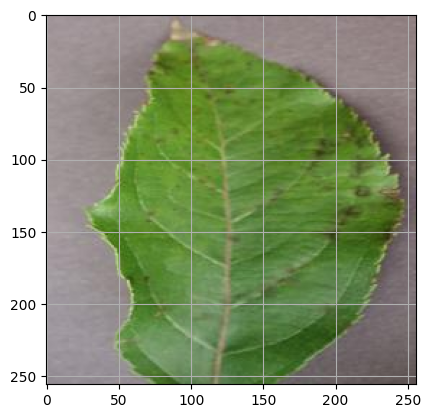

In [51]:
img = mpimg.imread('plantvillage dataset/color/Apple___Apple_scab/0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417.JPG')
print('Shape:', img.shape) # 256,256,3. 3 here indicates that this is a RGB image.
plt.imshow(img)
plt.axis('on')
plt.grid(True)

In [52]:
# Image parameters
img_size = 64 # New custom size: For all input images, resize happens and this helps in faster model building
batch_size = 64

##### Train Test Split

In [53]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale = 1./255, # Rescaling the images
    validation_split = 0.2 # Using 20% of images for validation
)

In [54]:
# Data Generation Pipelines
# Training Data Generator
train_gen = data_gen.flow_from_directory( # Flow from directory applies the generation on all the data present in the given directory
    dataset_path,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'categorical'
)

# Validation Data Generator
val_gen = data_gen.flow_from_directory(
    dataset_path,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'categorical'
)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


##### Convolution Neural Network

In [55]:
# Required libraries
import keras as kr
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

In [56]:
# Model Building
model = Sequential() # This is the basic model. Now we will add layers to it.

# First Convolution-Pooling Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', input_shape = (img_size, img_size, 3)))
# input_shape = (img_size, img_size, 3) bacause these images are RGB images and therefore has 3 channels. If it would have been grayscale images, then we could ignore the third param
model.add(MaxPooling2D(pool_size = (2,2)))

# Second Convolution-Pooling Layer
model.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Flattening Layer
model.add(Flatten()) # So that each node can be considered as a seperate neuron

# Dense Layer 1 (Fully Connected Neural Network)
model.add(Dense(256, activation='relu'))

# Output Layer
model.add(Dense(units = train_gen.num_classes, activation = 'softmax')) # Multi-class classification. Hence applied Softmax Activation. 
# For each output class, we need to assign a neuron. So, the number of units of neuron is fetched by the num_classes parameter in the train_gen

In [73]:
# Model Summary (Information about the layers)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,722,036 (37.09 MB)

 Trainable params: 3,240,678 (12.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,481,358 (24.72 MB)

In [58]:
# Model Compilation
model.compile(optimizer = kr.optimizers.Adam(), loss = kr.losses.categorical_crossentropy, metrics = ['accuracy'])

In [59]:
# Model training / fitting
history = model.fit(
    train_gen, # training data
    steps_per_epoch = train_gen.samples // batch_size, # train_gen.samples generates the number of data present
    epochs = 5, # Number of epoch
    validation_data = val_gen,
    validation_steps = val_gen.samples // batch_size   
)

Epoch 1/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 132s 193ms/step - accuracy: 0.6888 - loss: 1.0890 - val_accuracy: 0.8111 - val_loss: 0.6027
Epoch 2/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - accuracy: 0.8677 - loss: 0.4150 - val_accuracy: 0.8709 - val_loss: 0.4117
Epoch 3/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 95s 139ms/step - accuracy: 0.9186 - loss: 0.2513 - val_accuracy: 0.9035 - val_loss: 0.3092
Epoch 4/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 96s 141ms/step - accuracy: 0.9449 - loss: 0.1670 - val_accuracy: 0.8982 - val_loss: 0.3310
Epoch 5/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 93s 137ms/step - accuracy: 0.9573 - loss: 0.1266 - val_accuracy: 0.9014 - val_loss: 0.3152


In [60]:
# Model Evaluation
val_loss, val_accuracy = model.evaluate(val_gen, steps = val_gen.samples // batch_size)
print(f'Validation Accuracy: {val_accuracy * 100:4.2f} | Validation Loss: {val_loss:4.2f}')

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9014 - loss: 0.3153
Validation Accuracy: 90.14 | Validation Loss: 0.32


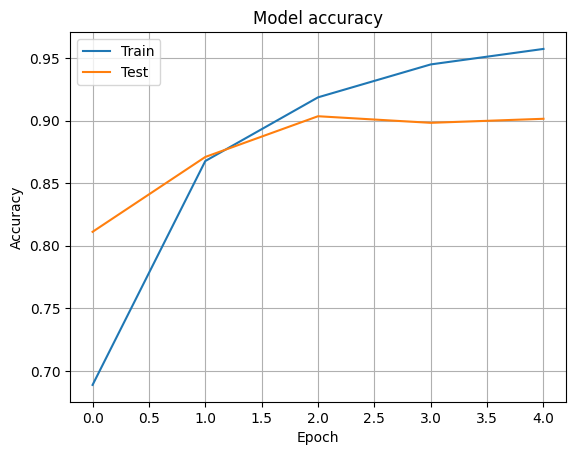

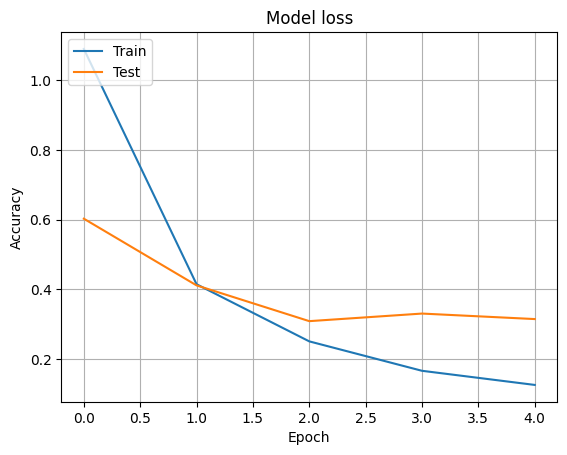

In [70]:
# Plotting the accuracy of train and test
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.grid(True)
plt.show()

# Plotting the loss of train and test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.grid(True)
plt.show()

##### Building a predicition system

In [ ]:
def preprocess(img_path, target_size = (64,64)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_arr = np.array(img) # Converting the image to a numpy array
    img_arr = np.expand_dims(img_arr, axis = 0) # Adding the batch dimension: Why? Adding a batch dimension makes the image shape (1, 64, 64, 3) instead of (64, 64, 3), because deep learning models expect input in batches — even if it’s just one image.
    img_arr = img_arr.astype('float32') / 255
    return img_arr

def predict(model, img_path, class_indices):
    preprocessed_img = preprocess(img_path)
    pred = model.predict(preprocessed_img)
    pred_class_idx = np.argmax(pred, axis = 1)[0] # np.argmax(pred, axis=1) finds which class has the highest predicted probability for each image in the batch. Since model.predict() returns something like [[0.1, 0.7, 0.2]], np.argmax(..., axis=1) -> [1] (the index of the max value). Then [0] just extracts that single index from the array — because you predicted only one image.
    
    pred_class_name = class_indices[pred_class_idx]
    return pred_class_name    

In [ ]:
# Creating the mapping from class indices to class names
class_indices = {v: k for k,v in train_gen.class_indices.items()}
print(class_indices)

{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'To

In [78]:
# We need to save this class indices locally
import json
with open('class_indices.json', 'w') as file:
    json.dump(class_indices, file)
    
# We also need to save the model locally
model.save('plant_disease_prediction.h5')

In [79]:
# Sample Prediction
image_path = '0a0b8f78-df2d-4cfc-becf-cde10fa2766b___RS_HL 5487.JPG' # It is a blueberry healthy image
pred_class_name = predict(model, image_path, class_indices)
print(pred_class_name) # Correct prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Blueberry___healthy
